## Colab

In [21]:
!pip install transformers
!pip install torch
!pip install emoji

In [2]:
import os
print(os.getcwd())

# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('./MyDrive')

/content
Mounted at ./MyDrive


In [3]:
cd MyDrive/MyDrive/Capstone/code_data

/content/MyDrive/MyDrive/Capstone/code_data


In [22]:
!pwd

/content/MyDrive/My Drive/Capstone/code_data


In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

## TFIDF

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X])
X_val_preprocessed = np.array([text_preprocessing(text) for text in test_X])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

KeyboardInterrupt: ignored

In [ ]:
print(X_train.shape)
print(X_train_tfidf.shape)

NameError: ignored

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


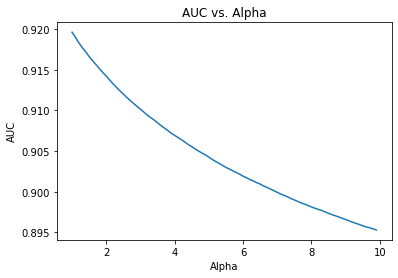

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

AUC: 0.9015
Accuracy: 82.10%


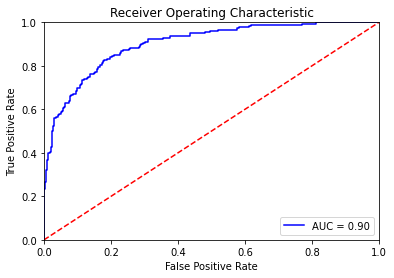

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

AUC: 0.5743
Accuracy: 50.00%


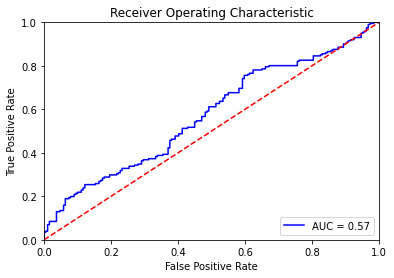

In [ ]:
# Compute predicted probabilities

# X_data = pd.concat([X_train_tfidf, X_val_tfidf], axis=0)
# y_data = pd.concat([X_train_tfidf, X_val_tfidf], axis=0)

X_test = test_data.text.values
y_test = test_data.isRumor.values

X_preprocessed = np.array([text_preprocessing(text) for text in X])
X_tfidf = tf_idf.transform(X_preprocessed)
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_tfidf, y)
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
evaluate_roc(probs, test_data.isRumor)

In [ ]:
from sklearn.metrics import classification_report
preds = np.argmax(probs, axis = 1)
print(classification_report(test_data.isRumor, preds))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       189
           1       1.00      0.03      0.06       201

    accuracy                           0.50       390
   macro avg       0.75      0.51      0.36       390
weighted avg       0.75      0.50      0.35       390



# 공통 Functions

## Library

In [1]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, f1_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import time

import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoModel, AutoTokenizer

from fetchData import fetchdata 
import __MLP

import emoji
pd.set_option('display.max_columns', None)

## Functions

In [2]:
def getDevice():
  if torch.cuda.is_available():       
      device = torch.device("cuda")
      print(f'There are {torch.cuda.device_count()} GPU(s) available.')
      print('Device name:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def preprocessing_for_bert(data): 

    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs (빈 리스트 2개 생성)
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            # max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask

            # max_length=True,                  # Max length to truncate/pad
            padding='max_length'
        )

        # Add the outputs to the lists (위의 빈 리스트에 상응하는 값 추가)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors (리스트들을 텐서화)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    best_acc = 0
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(
                t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(
                    f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            es = 0
            # torch.save(model.state_dict(), "model_" + str(epoch_i) + 'weight.pt')
            torch.save(model.state_dict(), "checkpoint.pt")
        else:
            es += 1
            print("Counter {} of 5".format(es))

            if es > 1:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_accuracy, "...")
                break

    model.load_state_dict(torch.load("checkpoint.pt"))
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def data_process(X_train, y_train, X_val, y_val, batch_size=32):
  # Concatenate train data and test data
  all_tweets = np.concatenate([X_train, X_val])

  # Encode our concatenated data
  encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

  # Find the maximum length
  max_len = max([len(sent) for sent in encoded_tweets])
  print('Max length: ', max_len)

  # Specify `MAX_LEN`
  MAX_LEN = max_len

  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('\nTokenizing data...')
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)

  # Convert other data types to torch.Tensor
  train_labels = torch.tensor(y_train)
  val_labels = torch.tensor(y_val)

  # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 8

  # Create the DataLoader for our training set
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set
  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

  return train_dataloader, val_dataloader

def train_process(train_dataloader, val_dataloader, epoch=4):
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=epoch)

  train(bert_classifier, train_dataloader, loss_fn, epochs=4, evaluation=True)

  return bert_classifier

def testing_process(bert_classifier, X_val, y_val):
  #  Run `preprocessing_for_bert` on the test set
  print('Tokenizing data...')
  test_inputs, test_masks = preprocessing_for_bert(X_val)

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

  # Compute predicted probabilities on the test set
  probs = bert_predict(bert_classifier, test_dataloader)

  # Get predictions from the probabilities
  threshold = 0.5
  preds = np.where(probs[:, 1] > threshold, 1, 0)

  # Number of tweets predicted non-negative
  print("Number of tweets predicted as Rumor: ", preds.sum())

  preds = np.argmax(probs, axis = 1)
  print("\n",classification_report(y_val, preds))
  print('Accuracy Score:\t',accuracy_score(y_val, preds))
  print('Precision Score:\t', str(precision_score(y_val,preds)))
  print('Recall Score:\t\t' + str(recall_score(y_val,preds)))
  print('F1 Score:\t',f1_score(y_val, preds, zero_division=1))

# BERT 최종


## Functions

In [3]:
def text_preprocessing(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = text.lower()
    # text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r"(#)(\S+)", r'\1 \2', text) # 해쉬태그 띄우기

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'

    # text = re.sub(r"@\S+", "@", text)   # mention -> '@'
    # text = re.sub(r"@[^\s]+", "@", text)   # mention -> '@'

    # sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
    
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      # lr=5e-5,    # Default learning rate
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    criterion = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, criterion

class BertClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [4]:
class BertClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Executions

In [5]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv').text.values
rhi_y = pd.read_csv('data/_RHI_text.csv').isRumor

In [6]:
val

,text,Event,target
0,Micheal Essien denying the Ebola rumours like ...,ebola-essien,1
1,No truth in internet rumours that I have contr...,ebola-essien,1
2,Essien and his lawyers are considering to file...,ebola-essien,1
3,Good news: The rumours that Michael Essien has...,ebola-essien,1
4,Milan have stated that the reports about Essie...,ebola-essien,1
...,...,...,...
480,Ex-KGB Yuri Shvets at #Litvinenko inquiry-#Put...,putinmissing,0
481,"Death came for Pratchett, picked up Putin for ...",putinmissing,0
482,the plot thickens - #putindead http://t.co/Vie...,putinmissing,0
483,Putin juggling enough instability. He would ma...,putinmissing,0


In [34]:
device = getDevice()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# train_dataloader, val_dataloader = data_process(X_train, y_train, X_val, y_val, batch_size=6)
train_dataloader, val_dataloader = data_process(X_train[0:100], y_train[0:100], X_val[0:100], y_val[0:100], batch_size=32)

There are 1 GPU(s) available.
Device name: Tesla T4
Max length:  64

Tokenizing data...


In [35]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=3)
# train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

RuntimeError: ignored

In [ ]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

In [ ]:
torch.save(bert_classifier.state_dict(), './Model/BERT_raw_to_fine_tune_ord4.pt')

AUC: 0.7044
Accuracy: 45.36%


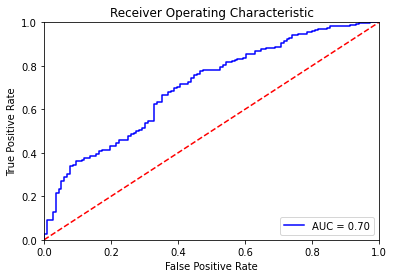

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
PATH = './Model/BERT_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

Tokenizing data...
Number of tweets predicted as Rumor:  122

               precision    recall  f1-score   support

           0       0.29      0.92      0.45       116
           1       0.93      0.31      0.46       369

    accuracy                           0.45       485
   macro avg       0.61      0.61      0.45       485
weighted avg       0.78      0.45      0.46       485

0.4536082474226804
0.4602851323828921


In [ ]:
rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')
X_test = rhi_data.text.values
y_test = rhi_y.isRumor.values

PATH = './Model/BERT_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_test, y_test)

Tokenizing data...
Number of tweets predicted as Rumor:  795

               precision    recall  f1-score   support

           0       0.10      0.94      0.18       475
           1       0.96      0.16      0.28      4752

    accuracy                           0.23      5227
   macro avg       0.53      0.55      0.23      5227
weighted avg       0.89      0.23      0.27      5227

0.23225559594413622
0.27654588065621055


# BERTweet

## Functions

In [7]:
def text_preprocessing(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = text.lower()
    # text = re.sub(r'(@.*?)[\s]', ' ', text)
    # text = re.sub(r"(#)(\S+)", r'\1 \2', text)

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'

    # text = re.sub(r"@\S+", "@", text)   # mention -> '@'
    # text = re.sub(r"@[^\s]+", "@", text)   # mention -> '@'

    # sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def initialize_model(epochs=4, freeze_bert=False):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertTweetClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    criterion = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, criterion

### Class

In [8]:
class BertTweetClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertTweetClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    def embedding(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        last_hidden_state_cls = outputs[0][:, 0, :]

        return last_hidden_state_cls  # sequence_output, pooled_output, (hidden_states), (attentions)

## Execution

In [9]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv').text.values
rhi_y = pd.read_csv('data/_RHI_text.csv').isRumor

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5802,) (5802,)
(485,) (485,)


In [11]:
device = getDevice()
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
train_dataloader, val_dataloader = data_process(X_train, y_train, X_val, y_val, batch_size=8)

No GPU available, using the CPU instead.


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Max length:  58

Tokenizing data...


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.657699   |     -      |     -     |   4.73   
   1    |   40    |   0.572159   |     -      |     -     |   4.54   
   1    |   60    |   0.599299   |     -      |     -     |   4.65   
   1    |   80    |   0.502215   |     -      |     -     |   4.70   
   1    |   100   |   0.424222   |     -      |     -     |   4.74   
   1    |   120   |   0.471874   |     -      |     -     |   4.66   
   1    |   140   |   0.555176   |     -      |     -     |   4.64   
   1    |   160   |   0.485429   |     -      |     -     |   4.55   
   1    |   180   |   0.442740   |     -      |     -     |   4.51   
   1    |   200   |   0.574039   |     -      |     -     |   4.47   
   1    |   220   |   0.487704   |     -      |     -     |   4.47   
   1    |   240   |   0.527812   |     -      |     -     |   4.45   


In [ ]:
torch.save(bert_classifier.state_dict(), './Model/BERTweet_raw_to_fine_tune_ord5.pt')

AUC: 0.4855
Accuracy: 62.89%


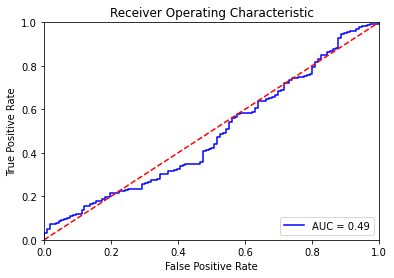

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

Tokenizing data...
Number of tweets predicted as Rumor:  391

               precision    recall  f1-score   support

           0       0.22      0.18      0.20       116
           1       0.76      0.80      0.78       369

    accuracy                           0.65       485
   macro avg       0.49      0.49      0.49       485
weighted avg       0.63      0.65      0.64       485

0.6536082474226804
0.7789473684210527


In [ ]:
rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')
X_test = rhi_data.text.values
y_test = rhi_y.isRumor.values

PATH = './Model/BERTweet_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_test, y_test)

Tokenizing data...
Number of tweets predicted as Rumor:  3823

               precision    recall  f1-score   support

           0       0.11      0.33      0.17       475
           1       0.92      0.74      0.82      4752

    accuracy                           0.70      5227
   macro avg       0.52      0.54      0.49      5227
weighted avg       0.84      0.70      0.76      5227

0.7013583317390473
0.8179591836734694


---

# BERTweet Embedding Only

#### BERT & EMOJI 이모지 다루는 차이 😂😂😂😂😂

> Before applying fastBPE to the pre-training corpus of 850M English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets. BERTweet provides this pre-processing step by enabling the normalization argument.



In [12]:
# INPUT TWEET IS ALREADY NORMALIZED!
# print("<Normal text>")
# line = "@MichaelEssien that's a shame wanted to Invest in you😔😂😂"
# print(line)
# print(tokenizer.encode(line),"\n")
# input_ids = torch.tensor([tokenizer.encode(line)])
# # print(input_ids)

print("<Normal text>")
line = "https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line,"\n")
print(line.split())
print("\n",tokenizer.encode(line),"\n")
print("--------------------------------------------------")

print("<Demojized text>")
# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
line = "https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
line = emoji.demojize(line)
print(line,"\n")
print(line.split())
print("\n",tokenizer.encode(line),"\n")
print("--------------------------------------------------")

print("<Demojized & http text>")
# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
line = "https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
line = emoji.demojize(line)
line = re.sub(r"http\S+", "HTTPURL", line)  # http link -> '*'
print(line,"\n")
print(line.split())
print("\n",tokenizer.encode(line),"\n")
print("--------------------------------------------------")

print("<Demojized & http & Mention text>")
# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
line = "https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
line = emoji.demojize(line)
line = re.sub(r"http\S+", "HTTPURL", line)  # http link -> '*'
line = re.sub(r"@\S+", "@USER", line)   # mention -> '@'
print(line,"\n")
print(line.split())
input_ids = torch.tensor([tokenizer.encode(line)])
print("\n",tokenizer.encode(line),"\n")
print("--------------------------------------------------")

print("<Demojized-spaced & http & Mention text>")
# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
line = "https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
line = emoji.demojize(line)
line = re.sub(r"http\S+", "HTTPURL", line)  # http link -> '*'
line = re.sub(r"@\S+", "@USER", line)   # mention -> '@'
line = re.sub(r':[^:]*:', r' \g<0>', line)  # http link -> '*'
# input_ids = torch.tensor([tokenizer.encode(line)])
print(line,"\n")
print(line.split())
print("\n",tokenizer.encode(line),"\n")

print("<FINAL>")
# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
line = "https://www.naver.com bhang96@gmail.com 12:30 @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
print(line)
line = text_preprocessing(line)
print(line)
# input_ids = torch.tensor([tokenizer.encode(line)])
# print(line.split())
print("\n",tokenizer.encode(line),"\n")

# line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you pensive_face face_with_tears_of_joy face_with_tears_of_joy :grinning_face_with_big_eyes: HTTPURL  "
# input_ids = torch.tensor([tokenizer.encode(line)])
# print(line)
# print(tokenizer.encode(line))

# with torch.no_grad():
#     features = bertweet(input_ids)  # Models outputs are now tuples
# print(features)

<Normal text>
https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com 

['https://www.naver.com', '@MichaelEssien', "that's", 'a', 'shame', 'wanted', 'to', 'Invest', 'INVEST', 'in', 'you😔😂😂', 'http://www.google.com']

 [0, 62060, 8798, 3, 36110, 1626, 2237, 6354, 5238, 55508, 471, 10424, 818, 6139, 20, 11, 2536, 588, 9, 22630, 27227, 3969, 16, 3805, 3, 3, 3, 45565, 36110, 9485, 17048, 6354, 2] 

--------------------------------------------------
<Demojized text>
https://www.naver.com @MichaelEssien that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: http://www.google.com 

['https://www.naver.com', '@MichaelEssien', "that's", 'a', 'shame', 'wanted', 'to', 'Invest', 'INVEST', 'in', 'you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy:', 'http://www.google.com']

 [0, 62060, 8798, 3, 36110, 1626, 2237, 6354, 5238, 55508, 471, 10424, 818, 6139, 20, 11, 2536, 588, 9, 226

In [9]:
text = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂😃 http://www.google.com"
print(emoji.emoji_count(text),"\n")
print(text)
text = emoji.demojize(text)

# print(emoji.get_emoji_regexp(),"\n")
# text=text.strip(':')
# text = re.sub(r'(@.*?)[\s]', '@USER ', text)
text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
emojis = re.findall(r'(::)', text)
print(emojis)
# print(text,"\n")
text = re.sub(r':[^:]*:', r' \g<0>', text)  # http link -> '*'
print(text,"\n")

text=text.split()
# text= re.sub(r'(:[!_\-\w]+:)', '', text)
print(text,"\n")
# emojis

NameError: name 'emoji' is not defined

## FUCNTION & DTA

In [13]:
import torch
from transformers import AutoModel, AutoTokenizer 
import emoji
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

lemmatizer = WordNetLemmatizer()
tweetTokenizer = TweetTokenizer()

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

device = getDevice()
bert_classifier = BertTweetClassifier(freeze_bert=False)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

PATH = './Model/BERTweet_raw_embedding.pt'
# bert_classifier.load_state_dict(torch.load(PATH))

No GPU available, using the CPU instead.


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [19]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')
val_text = pd.read_csv('data/_PHEMEext_textonly.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv').text.values
rhi_y = pd.read_csv('data/_RHI_text.csv').isRumor

X_test = val.drop(['Event'],axis=1).text.values

In [23]:
    
# URL/USER -> TweetTkzr -> Emoji
def text_preprocessing_simple(text, lemma=False, twttknzr=True): # Create a function to tokenize a set of texts
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
    # text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
    
    text = re.sub(r"@[A-Za-z0-9]+", "@USER", text)   # mention -> '@'

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&amp;', '&', text)
    if twttknzr==True:
        text = tweetTokenizer.tokenize(text)
    else:
        text = text.split()
    if lemma==True:
        text = [lemmatizer.lemmatize(word) for word in text]
    text = [emoji.demojize(token) for token in text]
    return text
    
# URL/USER -> TweetTkzr -> Emoji

def text_preprocessing_simple2(text, lemma=False, twttknzr=True): # Create a function to tokenize a set of texts
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
    # text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
    
    text = re.sub(r"@[A-Za-z0-9]+", "@USER", text)   # mention -> '@'

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&amp;', '&', text)
    if twttknzr==True:
        text = tweetTokenizer.tokenize(text)
    else:
        text = text.split()
    if lemma==True:
        text = [lemmatizer.lemmatize(word) for word in text]
    text = [emoji.demojize(token) for token in text]
    return text

# 
def text_preprocessing_simple3(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    text = emoji.demojize(text)
    text = re.sub(r':[^:\s]*:', r' \g<0>', text)  # http link -> '*'

    # text = re.sub(r':[^:\s]*(?:::[^:\s]*)*:', r' \g<0> ', text)  # http link -> '*'

    # text = re.sub(r"\n", " ", text)   # mention -> '@'
    text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
    # text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
    
    text = re.sub(r"@[A-Za-z0-9]+", "@USER", text)   # mention -> '@'

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&amp;', '&', text)
    # text = tweetTokenizer.tokenize(text)
    # text = [emoji.demojize(token) for token in text]
    return text


class BertTweetClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertTweetClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    def embedding(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        last_hidden_state_cls = outputs[0][:, 0, :]

        return last_hidden_state_cls  # sequence_output, pooled_output, (hidden_states), (attentions)


def text_preprocessing(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    text = emoji.demojize(text)
    text = re.sub(r':[^:\s]*:', r' \g<0>', text)  # http link -> '*'

    # text = re.sub(r':[^:\s]*(?:::[^:\s]*)*:', r' \g<0> ', text)  # http link -> '*'

    # text = re.sub(r"\n", " ", text)   # mention -> '@'
    text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
    # text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'

    text = re.sub(r"@[A-Za-z0-9]+", "@USER", text)   # mention -> '@'

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&amp;', '&', text)
    # text = tweetTokenizer.tokenize(text)
    # text = [emoji.demojize(token) for token in text]

    return text

def text_preprocessing_brackets(text): # Create a function to tokenize a set of texts
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """

    text = emoji.demojize(text)
    text = re.sub(r':[^:\s]*:', r' \g<0>', text)  # http link -> '*'

    # text = re.sub(r':[^:\s]*(?:::[^:\s]*)*:', r' \g<0> ', text)  # http link -> '*'

    # text = re.sub(r"\n", " ", text)   # mention -> '@'
    text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
    # text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
    text = re.sub(r"(\w+@\w+.[\w+]{2,4})", "<email>", text)   

    
    text = re.sub(r"@[A-Za-z0-9]+", "@USER", text)   # mention -> '@'
    text = re.sub(r"\d+(\%|\s\bpercent\b)", "<percentage>", text)   # mention -> '@'
    text = re.sub(r"([0-1][0-9]|[2][0-3])[:|.|h]([0-5][0-9])", "<time>", text)   # mention -> '@'
    
    text = re.sub(r"([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)\d{4}", "<date>", text)  
    text = re.sub(r"(((0)[0-9])|((1)[0-2]))(\/)([0-2][0-9]|(3)[0-1])(\/)\d{4}", "<date>", text)  
    text = re.sub(r"\d{4}(\/)(((0)[0-9])|((1)[0-2]))(\/)([0-2][0-9]|(3)[0-1])", "<date>", text)  
    text = re.sub(r'[0-9]+[.][0-9]+', "<number>", text)   # mention -> '@'

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&amp;', '&', text)

    return text


def getEmbeddingBERT(bert_classifier, data):
    bert_classifier.eval()
    input_ids = []
    attention_masks = []
    result = []

    # For every sentence...
    for index, sent in enumerate(data):
        encoded_sent = tokenizer.encode(
            text=text_preprocessing_brackets(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask

            padding='do_not_pad'
        )
        with torch.no_grad():
            encoded_sent = torch.tensor([encoded_sent])
            # print(encoded_sent)
            last_hidden_state = bert_classifier.embedding(encoded_sent)

        result.append(last_hidden_state)

        if (index % 300 == 0 or index == len(input_ids)): print("Current number of processed tweets: {}".format(index))
    return result

### Another Checking

In [223]:
# print(tokenizer.encode("😅"),"\n")
# print(tokenizer.encode("grinning_face_with_sweat"),"\n")
# print(tokenizer.encode(":grinning_face_with_sweat:"),"\n\n")
sent = "It's Good news: The rumours that Michael Essien has contracted the Ebola virus are false. 30% @bg http://t.co/5d7hCL46mR http://t.co/VtGuLnjWBD 😅😅 @asdfas"
print("Original:\t\t",sent)
print("_____________________")
print("바로 토큰화:\t\t",tokenizer.encode(sent.split()))
ids = tokenizer.encode(sent.split())
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")

print("정제 한 후 토큰화:\t\t",tokenizer.encode(text_preprocessing_simple(sent)))
ids = tokenizer.encode(text_preprocessing_simple(sent))
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")

print("정제만 하기:\t\t",tokenizer.encode(text_preprocessing_pos(sent)))
ids = tokenizer.encode(text_preprocessing_pos(sent))
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")

print("정제만 하기 + split():\t",tokenizer.encode(text_preprocessing_pos(sent).split()))
ids = tokenizer.encode(text_preprocessing_pos(sent).split())
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")

print("정제만 하기 + TwtTknzr:\t",tokenizer.encode(text_preprocessing_pos(sent).split()))
ids = tokenizer.encode(tweetTokenizer.tokenize(text_preprocessing_pos(sent)))
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")

print("정제만 하기 + Brackets:\t",tokenizer.encode(text_preprocessing_brackets(sent).split()))
ids = tokenizer.encode(text_preprocessing_brackets(sent))
print("\t\t\t",tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids)),"\n")
# print("tweetTokenizer:\t",tokenizer.encode(result.split()),"\n")

Original:		 It's Good news: The rumours that Michael Essien has contracted the Ebola virus are false. 30% @bg http://t.co/5d7hCL46mR http://t.co/VtGuLnjWBD 😅😅 @asdfas
_____________________
바로 토큰화:		 [0, 3, 417, 3, 47, 16368, 25, 1424, 3, 90, 32976, 6, 15930, 4892, 41, 3, 3, 3, 3, 3, 3, 3, 2]
			 <s> <unk> Good <unk> The rumours that Michael <unk> has contracted the Ebola virus are <unk> <unk> <unk> <unk> <unk> <unk> <unk> </s> 

정제 한 후 토큰화:		 [0, 3, 417, 615, 22, 47, 16368, 25, 1424, 3, 90, 32976, 6, 15930, 4892, 41, 4501, 4, 597, 221, 5, 10, 10, 1411, 1411, 5, 2]
			 <s> <unk> Good news : The rumours that Michael <unk> has contracted the Ebola virus are false . 30 % @USER HTTPURL HTTPURL :grinning_face_with_sweat: :grinning_face_with_sweat: @USER </s> 

정제만 하기:		 [0, 4543, 20, 417, 6308, 11891, 47, 16368, 25, 1424, 471, 10424, 818, 90, 32976, 6, 15930, 4892, 41, 41129, 4, 2774, 221, 5, 10, 10, 1411, 1411, 5, 2]
			 <s> It's Good news: The rumours that Michael Essien has contracted the

In [217]:
'''
첫번째는 
'''
sent = "23/03/2019 03/23/2019 2019/03/23 child is jotgatten \n@JUNE 100% 1% | 12:30 13-40 12-30 12.30 1230 | bhang@adsf.com 100 http://www.naver.com"

encoded_sent = tokenizer.encode(
            text=text_preprocessing_simple(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask
            padding='do_not_pad'
        )
encoded_sent2 = tokenizer.encode(
            text=text_preprocessing_simple2(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask
            padding='do_not_pad'
        )
encoded_sent3 = tokenizer.encode(
            text=text_preprocessing_simple3(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask
            padding='do_not_pad'
        )
encoded_sent4 = tokenizer.encode(
            text=text_preprocessing_brackets(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask
            padding='do_not_pad'
        )

encoded_sent5 = tokenizer.encode(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            return_attention_mask=False,      # Return attention mask
            padding='do_not_pad'
        )
print(sent)
print()
print(encoded_sent)
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_sent)))
print()
print(encoded_sent2)
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_sent2)))
print()
print(encoded_sent3)
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_sent3)))
print()
print(encoded_sent4)
print(text_preprocessing_brackets(sent))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_sent4)))
print()
print(encoded_sent5)
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_sent5)))

23/03/2019 03/23/2019 2019/03/23 child is jotgatten 
@JUNE 100% 1% | 12:30 13-40 12-30 12.30 1230 | bhang@adsf.com 100 http://www.naver.com

[0, 3, 75, 1126, 3, 75, 1126, 3, 75, 1221, 1052, 17, 3, 5, 550, 221, 167, 221, 216, 15895, 3, 3, 3, 59394, 216, 3, 550, 10, 2]
<s> <unk> / 2019 <unk> / 2019 <unk> / 23 child is <unk> @USER 100 % 1 % | 12:30 <unk> <unk> <unk> 1230 | <unk> 100 HTTPURL </s>

[0, 3, 75, 1126, 3, 75, 1126, 3, 75, 1221, 1052, 17, 3, 5, 550, 221, 167, 221, 216, 15895, 3, 3, 3, 59394, 216, 3, 550, 10, 2]
<s> <unk> / 2019 <unk> / 2019 <unk> / 23 child is <unk> @USER 100 % 1 % | 12:30 <unk> <unk> <unk> 1230 | <unk> 100 HTTPURL </s>

[0, 40260, 26329, 1126, 26329, 40260, 1126, 43130, 26329, 1221, 1052, 17, 2998, 27582, 5023, 818, 5, 3919, 221, 1032, 221, 216, 15895, 14842, 971, 8447, 597, 9047, 597, 59394, 216, 607, 13728, 5238, 2479, 2899, 6354, 550, 10, 2]
<s> 23/03/2019 03/23/2019 2019/03/23 child is jotgatten @USER 100% 1% | 12:30 13-40 12-30 12.30 1230 | bhang@USER.com 

In [49]:
sent = "23/03/2019 03/23/2019 2019/03/23 child is jotgatten \n@JUNE 100% 1% | 12:30 13-40 12-30 12.30 1230 | bhang@adsf.com 100 http://www.naver.com"
sent = "A value iss trying to be set on a copys of an slices from a DataFrame"
# sent = raw_text.text[10]
print(text_preprocessing_simple(sent))
print(text_preprocessing_brackets(sent))
print(text_preprocessing_simple(sent, lemma=True))
print(text_preprocessing_simple(sent, twttknzr=True))

['A', 'value', 'iss', 'trying', 'to', 'be', 'set', 'on', 'a', 'copys', 'of', 'an', 'slices', 'from', 'a', 'DataFrame']
['A', 'value', 'iss', 'trying', 'to', 'be', 'set', 'on', 'a', 'copys', 'of', 'an', 'slices', 'from', 'a', 'DataFrame']
['A', 'value', 'i', 'trying', 'to', 'be', 'set', 'on', 'a', 'copy', 'of', 'an', 'slice', 'from', 'a', 'DataFrame']
['A', 'value', 'iss', 'trying', 'to', 'be', 'set', 'on', 'a', 'copys', 'of', 'an', 'slices', 'from', 'a', 'DataFrame']


In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
for index, sent in enumerate(raw_text.text):
    raw_text['Event'][index] = text_preprocessing_simple(sent)

<ipython-input-52-a21585fe752d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_text['Event'][index] = text_preprocessing_simple(sent)


In [62]:
# tokens = pd.DataFrame({})
tokens = []
# for index, sent in enumerate(raw_text.text):
final = [text_preprocessing_simple(sent) for sent in raw_text.text]
final = pd.DataFrame(final)

In [64]:
final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,BREAKING,:,Armed,man,takes,hostage,in,kosher,grocery,east,of,Paris,HTTPURL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,#CharlieHebdo,killers,"dead,",confirmed,by,gendarmerie.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Top,French,cartoonists,"Charb,","Cabu,","Wolinski,",Tignous,confirmed,among,dead,in,#Paris,#CharlieHebdo,attack.,Editor,is,critically,wounded.,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Police,have,surrounded,the,area,where,the,#CharlieHebdo,attack,suspects,are,believed,to,be,:,HTTPURL,HTTPURL,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,PHOTO,:,Armed,gunmen,face,police,officers,near,#CharlieHebdo,HQ,in,Paris,HTTPURL,HTTPURL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,'I'll,ride,with,you',http,://t.co/llZnuCAzg5,Australia,unites,during,#SydneySiege,HTTPURL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5798,Canada's,thoughts,and,prayers,are,with,our,Australian,friends.,#MartinPlace,#SydneySiege,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5799,Every,non-muslim,in,the,world,must,watch,this,video,HTTPURL,&,show,it,every,other,non-muslim!,#sydneysiege,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5800,Suspect,in,Sydney,cafe,siege,identified,as,Man,Haron,"Monis,",an,Iranian,granted,asylum,in,Australia,HTTPURL,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [65]:
# result.loc[result.iloc[:,:]=='BREAKING:']
final[final.eq(r"[:)|:-)|8-)|:-|:-))]").any(1)]
final[final.eq(r"[:-(|:(|:-]+").any(1)]
# print(raw_text.iloc[2944])
# raw_text[r"<percentage>" in raw_text.Event.values]
search = final[final.eq(r"<number>").any(1)]
# print(search.index.values)
search
# result.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30


In [457]:
raw_text.iloc[search.index.values]

,text,Event,target
1024,"-Muslim shooter - 1.7 Billion Muslims guilty\n\n-Black shooter - ""All Blacks are violent""\n\n-White Shooter - ""Lone Wolf""\n\n#CharlieHebdo","[-Muslim, shooter, -, <number>, Billion, Muslims, guilty, -Black, shooter, -, ""All, Blacks, are, violent"", -White, Shooter, -, ""Lone, Wolf"", #CharlieHebdo]",0
3272,"A @germanwings A322 #4U9525, BCN-DUS, with at least 143 passengers has crashed today at 9.39 UTC http://t.co/L7Wtodurt7","[A, @USER, A322, #4U9525,, BCN-DUS,, with, at, least, 143, passengers, has, crashed, today, at, <number>, UTC, HTTPURL]",1
3613,"I don't get it ... The #Germanwings flight descended 31.000 feet in 10 minutes and didn't change course at all, acc. to Flightradar data ...","[I, don't, get, it, ..., The, #Germanwings, flight, descended, <number>, feet, in, 10, minutes, and, didn't, change, course, at, all,, acc., to, Flightradar, data, ...]",0
4187,"Sad about #OttawaShooting. Worse, shooter might b guy who calls himself Muslim. Pls world dont judge 1.5 billion Muslims by some extremists.","[Sad, about, #OttawaShooting., Worse,, shooter, might, b, guy, who, calls, himself, Muslim., Pls, world, dont, judge, <number>, billion, Muslims, by, some, extremists.]",0
4388,"In his last three games, Kobe is averaging 26.7 points on 42% shooting, 4.3 rebounds and 3.7 assists in 31.3 minutes. #MathIsFun","[In, his, last, three, games,, Kobe, is, averaging, <number>, points, on, <percentage>, shooting,, <number>, rebounds, and, <number>, assists, in, <number>, minutes., #MathIsFun]",0
5367,"#NSW police have asked us, and others, not to broadcast demands from the #lindtcafe gunman. We will comply. I will have more to say at 7.30","[#NSW, police, have, asked, us,, and, others,, not, to, broadcast, demands, from, the, #lindtcafe, gunman., We, will, comply., I, will, have, more, to, say, at, <number>]",0
5724,The gunman is also holding 1.6 billion Muslims hostage. Islam is free from the crimes he's committing against innocents. #SydneySiege,"[The, gunman, is, also, holding, <number>, billion, Muslims, hostage., Islam, is, free, from, the, crimes, he's, committing, against, innocents., #SydneySiege]",0


In [50]:
pd.DataFrame(raw_text[['tokens','text']]).sample(20)

KeyError: "['tokens'] not in index"

## EMBEDDING PROCESS

The proper method I chose is 
1. 

In [24]:
device = getDevice()
bert_classifier = BertTweetClassifier(freeze_bert=False)

# PATH = './Model/BERTweet_raw_embedding.pt'
# bert_classifier.load_state_dict(torch.load(PATH))

No GPU available, using the CPU instead.


In [36]:
def getEmbeddingBERT(bert_classifier, data):
  bert_classifier.eval()
  input_ids = []
  attention_masks = []
  result = []

  # For every sentence...
  for index, sent in enumerate(data):
      encoded_sent = tokenizer.encode(
          text=text_preprocessing(sent),  # Preprocess sentence
          add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
          return_attention_mask=False,      # Return attention mask

          padding='do_not_pad'
      )
      with torch.no_grad():
          encoded_sent = torch.tensor([encoded_sent])
          # print(encoded_sent)
          last_hidden_state = bert_classifier.embedding(encoded_sent)

      result.append(last_hidden_state)

      if (index % 100 == 0 or index == len(input_ids)): print("Current number of processed tweets: {}".format(index))
  return result

In [37]:
result_pheme = getEmbeddingBERT(bert_classifier,X_train)
df_result_pheme = pd.DataFrame([sent[0].tolist() for sent in result_pheme]).add_prefix('BERTEmbed_')
df_result_pheme.to_csv('./data/_PHEME_Bert_final_simple_nrmzd2.csv', index = False)

Current number of processed tweets: 0
Current number of processed tweets: 100
Current number of processed tweets: 200
Current number of processed tweets: 300
Current number of processed tweets: 400
Current number of processed tweets: 500
Current number of processed tweets: 600
Current number of processed tweets: 700
Current number of processed tweets: 800
Current number of processed tweets: 900
Current number of processed tweets: 1000
Current number of processed tweets: 1100
Current number of processed tweets: 1200
Current number of processed tweets: 1300
Current number of processed tweets: 1400
Current number of processed tweets: 1500
Current number of processed tweets: 1600
Current number of processed tweets: 1700
Current number of processed tweets: 1800
Current number of processed tweets: 1900
Current number of processed tweets: 2000
Current number of processed tweets: 2100
Current number of processed tweets: 2200
Current number of processed tweets: 2300
Current number of processed 

In [33]:
result_val = getEmbeddingBERT(bert_classifier,X_val)
df_result_val = pd.DataFrame([sent[0].tolist() for sent in result_val]).add_prefix('BERTEmbed_')
df_result_val.to_csv('./data/_PHEMEext_Bert_final_brackets_nrmzd.csv', index = False)

Current number of processed tweets: 0
Current number of processed tweets: 100
Current number of processed tweets: 200
Current number of processed tweets: 300
Current number of processed tweets: 400
Current number of processed tweets: 500
Current number of processed tweets: 600


In [23]:
result_rhi = getEmbeddingBERT(bert_classifier,rhi_data)
df_result_rhi = pd.DataFrame([sent[0].tolist() for sent in result_rhi]).add_prefix('BERTEmbed_')
df_result_rhi.to_csv('./data/_RHI_Bert_final_brackets_nrmzd.csv', index = False)


Current number of processed tweets: 0
Current number of processed tweets: 300
Current number of processed tweets: 600
Current number of processed tweets: 900
Current number of processed tweets: 1200
Current number of processed tweets: 1500
Current number of processed tweets: 1800
Current number of processed tweets: 2100
Current number of processed tweets: 2400
Current number of processed tweets: 2700
Current number of processed tweets: 3000
Current number of processed tweets: 3300
Current number of processed tweets: 3600
Current number of processed tweets: 3900
Current number of processed tweets: 4200
Current number of processed tweets: 4500
Current number of processed tweets: 4800
Current number of processed tweets: 5100


In [202]:
df_result_pheme.to_csv('./data/_PHEME_Bert_final.csv', index = False)
df_result_val.to_csv('./data/_PHEMEext_Bert_final.csv', index = False)

In [243]:
df_result_rhi.to_csv('./data/_RHI_Bert_final.csv', index = False)

In [471]:
df_result_pheme

BERTEmbed_0  BERTEmbed_1  BERTEmbed_2  BERTEmbed_3  BERTEmbed_4  BERTEmbed_5  BERTEmbed_6  BERTEmbed_7  BERTEmbed_8  BERTEmbed_9  BERTEmbed_10  BERTEmbed_11  BERTEmbed_12  BERTEmbed_13  BERTEmbed_14  BERTEmbed_15  BERTEmbed_16  BERTEmbed_17  BERTEmbed_18  BERTEmbed_19  BERTEmbed_20  \
0       -0.112559     0.256139     0.171227    -0.076553     0.143061    -0.062029    -0.072677    -0.112627     0.171462    -0.207341     -0.046663      0.078731     -0.039187     -0.128192     -0.095857     -0.287233      0.018149      0.122441      0.475947      0.299201      0.067449   
1       -0.227629     0.225224     0.231292    -0.106223     0.059433     0.013205     0.105225     0.030600     0.051235    -0.101789      0.027778      0.269350      0.082311     -0.017754     -0.038839     -0.310158      0.218842      0.006542      0.533929      0.198319      0.105475   
2       -0.156663     0.144015     0.121652    -0.039961     0.181759     0.034058     0.070990     0.120514    -0.091443    -0.222109      0.044104      0.158231      0.242143     -0.003043     -0.049446     -0.339215      0.057154      0.166102      0.481451      0.215605      0.102058   
3       -0.035580     0.188858    -0.003260    -0.130486     0.160150    -0.174751     0.095568    -0.080505     0.254445    -0.096919     -0.005112      0.146347     -0.020105     -0.144764      0.070111     -0.461313      0.020317      0.153474      0.449021      0.240020     -0.029829   
4       -0.224686     0.139598     0.108120    -0.051431     0.124639    -0.146919     0.009397    -0.076450    -0.057992    -0.182568     -0.011725      0.090582      0.098747     -0.098377      0.027371     -0.278408      0.022246      0.113622      0.423185      0.259460      0.067126   
...           ...          ...          ...          ...          ...          ...          ...          ...          ...          ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...           ...   
5797    -0.183800     0.165602     0.171669    -0.052956     0.278973    -0.130962     0.071228     0.057740    -0.056535    -0.209858      0.040720      0.107985      0.234738      0.008502     -0.075491     -0.251127      0.147424      0.144499      0.494582      0.306974      0.094688   
5798    -0.137193     0.145458     0.285109    -0.066712     0.093408    -0.177522     0.163986    -0.047016    -0.007576    -0.214706     -0.058691      0.319188      0.190422      0.076463     -0.063008     -0.267173      0.041295      0.093231      0.581905      0.328003      0.056584   
5799    -0.186172     0.179648     0.243748    -0.100095     0.083960    -0.264884     0.079414    -0.051943     0.027550    -0.117400     -0.082906      0.163883      0.084087     -0.070525     -0.012431     -0.201493      0.126095      0.039986      0.482932      0.263607      0.112378   
5800    -0.132067     0.130876     0.161276    -0.091357     0.177120    -0.033335    -0.097726     0.020873     0.154972    -0.165567     -0.088746      0.181572      0.051574     -0.242877     -0.129602     -0.295245      0.023770      0.104712      0.456264      0.377980     -0.022440   
5801    -0.197204     0.164000     0.139933    -0.060349     0.123922    -0.014345     0.071361     0.003858    -0.048259    -0.140171      0.033974      0.258364      0.103917     -0.137829     -0.077513     -0.288034      0.224880      0.034143      0.464200      0.316458      0.040942   

      BERTEmbed_21  BERTEmbed_22  BERTEmbed_23  BERTEmbed_24  BERTEmbed_25  BERTEmbed_26  BERTEmbed_27  BERTEmbed_28  BERTEmbed_29  BERTEmbed_30  BERTEmbed_31  BERTEmbed_32  BERTEmbed_33  BERTEmbed_34  BERTEmbed_35  BERTEmbed_36  BERTEmbed_37  BERTEmbed_38  BERTEmbed_39  BERTEmbed_40  \
0        -0.953918     -0.133265      0.001833      0.146900     -0.076164     -0.179670     -0.067646     -0.104437      0.086202      0.046614      0.256747     -0.470094     -0.067134      0.270478     -0.04956